# Image Classification
Classify Images and wether or not they have pizza or steak in the photo.  
This data will be sourced from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), particularly a subdivision of the images that only include  pizzas and steaks.  


In [38]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download & Inspect Data

In [2]:
# Download zip file of pizza_steak images
fileName = 'pizza_steak.zip'
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile(fileName, "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-13 02:33:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.40.187, 142.250.64.123, 142.250.72.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.40.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  20.6MB/s    in 5.1s    

2024-06-13 02:33:35 (20.4 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### Inspect The Data
The data is in a dir, `pizza_steak`.  
The dir has 2 subdirs, `test` and `train`.  
Each subdir has 2 subdirs, `pizza` and `steak`.  
Each `pizza` and `steak` dir has images included.

In [4]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [17]:
# 
# SUMMARY OF DATA
# 

parentDir = 'pizza_steak'
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk(parentDir):
  if(len(filenames) > 0):
      print(f"    {len(filenames)} images in '{dirpath}'.")
  else:
      print(f"DIR: '{dirpath}' has {len(dirnames)} dirs")

DIR: 'pizza_steak' has 2 dirs
DIR: 'pizza_steak/train' has 2 dirs
    750 images in 'pizza_steak/train/pizza'.
    750 images in 'pizza_steak/train/steak'.
DIR: 'pizza_steak/test' has 2 dirs
    250 images in 'pizza_steak/test/pizza'.
    250 images in 'pizza_steak/test/steak'.


In [32]:
# 
# GET CLASS NAMES
# 
cleanPath = f'{parentDir}/train/'
trainingPath = pathlib.Path(cleanPath)
classNames = sorted([item.name for item in trainingPath.glob('*')])
npClassNames = np.array(classNames) # created a list of class_names from the subdirectories
print(npClassNames)

['pizza' 'steak']


### Preview Some Images

In [27]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


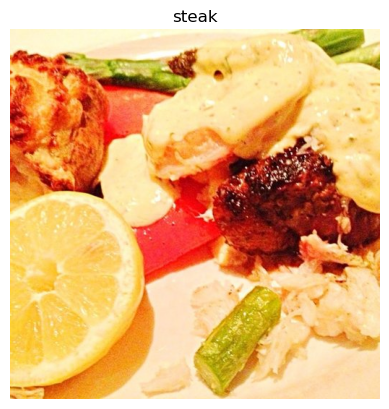

In [34]:
img = view_random_image(target_dir=cleanPath,
                        target_class="steak")

In [35]:
img

array([[[253, 244, 203],
        [254, 245, 204],
        [254, 245, 204],
        ...,
        [255, 248, 209],
        [255, 247, 208],
        [255, 246, 207]],

       [[252, 243, 202],
        [252, 243, 202],
        [252, 243, 202],
        ...,
        [255, 248, 209],
        [255, 247, 208],
        [255, 247, 208]],

       [[252, 243, 202],
        [252, 243, 202],
        [252, 243, 202],
        ...,
        [255, 246, 207],
        [255, 247, 208],
        [255, 247, 208]],

       ...,

       [[204, 146,  49],
        [206, 143,  48],
        [198, 127,  35],
        ...,
        [253, 219, 171],
        [253, 219, 174],
        [253, 219, 174]],

       [[232, 183,  90],
        [225, 172,  80],
        [216, 152,  64],
        ...,
        [254, 218, 170],
        [255, 218, 174],
        [255, 219, 175]],

       [[255, 216, 124],
        [254, 204, 115],
        [255, 196, 108],
        ...,
        [252, 216, 168],
        [253, 216, 172],
        [254, 217, 173]]

In [36]:
img.shape

(512, 512, 3)

NOTE:
- img

## Build A Model
### Prep the model Data

In [44]:
# Set the seed
tf.random.set_seed(42)
imgW = 224
imgH = 224
maxScaleNumber = 255
imagesInABatch = 32
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)
valid_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=imagesInABatch, # number of images to process at a time 
                                               target_size=(imgW, imgH), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=imagesInABatch,
                                               target_size=(imgW, imgH),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Build the Model

In [45]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
m1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
m1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = m1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
 3/47 [>.............................] - ETA: 3:28 - loss: 0.6963 - accuracy: 0.5000

KeyboardInterrupt: 